<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/Experiments/Transformer/TimeSeries/T02_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series

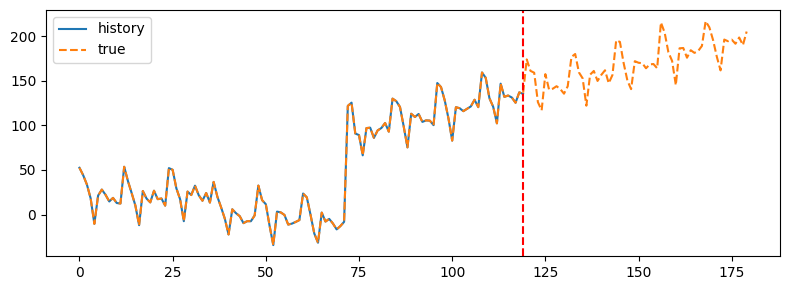

In [1]:
import numpy as np
np.random.seed(seed=42)
import matplotlib.pyplot as plt
import seaborn as sns

def trend(time):
    slope = np.zeros_like(a=time)
    slope[time < (3*12)] = 0.2
    slope[(time >= (3*12)) & (time < (6*12))] = -0.4
    slope[time >= (6*12)] = 1.0
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / float(period)
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=5):
    rnd = np.random.RandomState(seed=42)
    return rnd.randn(len(time)) * noise_level

period = 12; baseline = 10; amplitude = 40

time_history = np.arange(10*12, dtype=np.float32)
ts_history = baseline + trend(time=time_history)\
    + seasonality(time=time_history, period=period, amplitude=amplitude)\
    + noise(time=time_history)
ts_history = ts_history.astype(np.float32)

time_true = np.arange(15*12, dtype=np.float32)
ts_true = baseline + trend(time=time_true)\
    + seasonality(time=time_true, period=period, amplitude=amplitude)\
    + noise(time=time_true)
ts_true = ts_true.astype(np.float32)

plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history')
sns.lineplot(x=time_true, y=ts_true, label='true', linestyle='--')
plt.axvline(x=time_history[-1], color='red', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Dataset & DataLoader

In [2]:
from sklearn import preprocessing
import torch

torch.manual_seed(seed=42)

src_len = 24; tgt_len = 12
ts_train = ts_history[:-tgt_len]; ts_val = ts_history[-(src_len+tgt_len):]
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X=ts_train.reshape(-1, 1))
ts_train = scaler.transform(X=ts_train.reshape(-1, 1)).flatten()
ts_val = scaler.transform(X=ts_val.reshape(-1, 1)).flatten()

class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, ts, src_len, tgt_len):
        super().__init__()
        self.ts = torch.tensor(data=ts, dtype=torch.float32).view(-1, 1)
        self.src_len = src_len; self.tgt_len = tgt_len
        self.idxs = list(range(len(ts) - (src_len + tgt_len) + 1))

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        data = {}
        i = self.idxs[idx]

        src_start = i; src_end = i+self.src_len
        data['src'] = self.ts[src_start : src_end]
        data['src_idx'] = torch.arange(start=src_start, end=src_end,
            dtype=torch.long)

        tgt_start = i+self.src_len; tgt_end = i+self.src_len+self.tgt_len
        data['tgt'] = self.ts[tgt_start:tgt_end]
        data['tgt_idx'] = torch.arange(start=tgt_start, end=tgt_end,
            dtype=torch.long)

        return {k: v for k, v in data.items()}

def collate_fn(batch):
    out = {}
    for key in batch[0].keys():
        out[key] = torch.stack([b[key] for b in batch], dim=0)
    return out

batch_size = 32
ds_train = TrainingDataset(ts=ts_train, src_len=src_len, tgt_len=tgt_len)
dl_train = torch.utils.data.DataLoader(dataset=ds_train, shuffle=True,
    batch_size=batch_size, collate_fn=collate_fn)

ds_val = TrainingDataset(ts=ts_val, src_len=src_len, tgt_len=tgt_len)
dl_val = torch.utils.data.DataLoader(dataset=ds_val, shuffle=False,
    batch_size=batch_size, collate_fn=collate_fn)

data = next(iter(dl_val))
print({k: v.shape for k, v in data.items()})

{'src': torch.Size([1, 24, 1]), 'src_idx': torch.Size([1, 24]), 'tgt': torch.Size([1, 12, 1]), 'tgt_idx': torch.Size([1, 12])}


## Model

In [3]:
import torch
import math

torch.manual_seed(seed=42)

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        pe = torch.zeros(size=(max_len, d_model))
        position = torch.arange(start=0, end=max_len, dtype=torch.float32)\
            .unsqueeze(dim=1)
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2)
            .float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(dim=0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TimeSeriesForecast(torch.nn.Module):
    def __init__(self, in_dim=1, out_dim=1, d_model=128, max_len=50*12):
        super().__init__()
        self.input_proj = torch.nn.Linear(in_features=in_dim,
            out_features=d_model)

        self.idx_emb = torch.nn.Embedding(embedding_dim=8,
            num_embeddings=max_len)
        self.month_emb = torch.nn.Embedding(embedding_dim=8,
            num_embeddings=12)
        self.time_proj = torch.nn.Linear(in_features=16,
            out_features=d_model)

        self.positional = PositionalEncoding(d_model=d_model,
            max_len=max_len)

        self.encoder = torch.nn.TransformerEncoder(num_layers=2,
            encoder_layer=torch.nn.TransformerEncoderLayer(d_model=d_model,
                nhead=4, batch_first=True))

        self.decoder = torch.nn.TransformerDecoder(num_layers=2,
            decoder_layer=torch.nn.TransformerDecoderLayer(d_model=d_model,
                nhead=4, batch_first=True))

        self.output_proj = torch.nn.Linear(in_features=d_model,
            out_features=out_dim)

    def forward(self, data):
        src = self.input_proj(data['src'])
        src_time = torch.cat(tensors=[
            self.idx_emb(data['src_idx']),
            self.month_emb(data['src_idx'] % 12)
        ], dim=-1)
        src_time = self.time_proj(src_time)
        src = self.positional(src+src_time)
        memory = self.encoder(src)

        tgt = self.input_proj(data['tgt'])
        tgt_time = torch.cat(tensors=[
            self.idx_emb(data['tgt_idx']),
            self.month_emb(data['tgt_idx'] % 12)
        ], dim=-1)
        tgt_time = self.time_proj(tgt_time)
        tgt = self.positional(tgt+tgt_time)

        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(
            sz=tgt.size(1)).to(tgt.device)

        out = self.decoder(tgt=tgt, memory=memory, tgt_mask=tgt_mask)
        out = self.output_proj(out)
        return out

model = TimeSeriesForecast()
total_params = sum(p.numel() for p in model.parameters())
print("Total model parameters: %d"%(total_params))

Total model parameters: 2512161


## Training

In [4]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_step(model, dl_train, loss_fn, optimizer):
    model.train()
    losses = []
    for batch in dl_train:
        data = {k: v.to(device) for k, v in batch.items()}
        y_true = data['tgt']

        dec_in = torch.cat(tensors=[
            data['src'][:, -1:], data['tgt'][:, :-1]
        ], dim=1)
        dec_idx = torch.cat(tensors=[
            data['src_idx'][:, -1:], data['tgt_idx'][:, :-1]
        ], dim=1)

        data = {
            'src': batch['src'],
            'src_idx': batch['src_idx'],
            'tgt': dec_in,
            'tgt_idx': dec_idx
        }

        y_pred = model(data=data)
        loss = loss_fn(input=y_pred, target=y_true)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(),
            max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def val_step(model, dl_val, loss_fn):
    model.eval()
    losses = []
    for batch in dl_val:
        data = {k: v.to(device) for k, v in batch.items()}
        y_true = data['tgt']

        dec_in = torch.cat(tensors=[
            data['src'][:, -1:], data['tgt'][:, :-1]
        ], dim=1)
        dec_idx = torch.cat(tensors=[
            data['src_idx'][:, -1:], data['tgt_idx'][:, :-1]
        ], dim=1)

        data = {
            'src': batch['src'],
            'src_idx': batch['src_idx'],
            'tgt': dec_in,
            'tgt_idx': dec_idx
        }

        y_pred = model(data=data)
        loss = loss_fn(input=y_pred, target=y_true)
        losses.append(loss.item())
    return np.mean(losses)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss < (self.best_loss - self.min_delta):
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 3))
    sns.lineplot(data=df_history, x='epoch', y='train_loss', label='train')
    sns.lineplot(data=df_history, x='epoch', y='val_loss', label='val')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.title(label="loss vs. epoch")
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss (log scale)')
    plt.tight_layout()
    plt.show()

Training finished in 160.89s, best_val_loss=0.001474


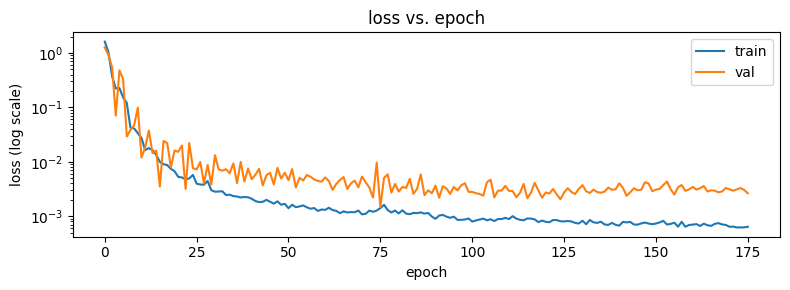

In [5]:
import os
import time
import torch

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TimeSeriesForecast().to(device)
loss_fn = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
    mode='min', factor=0.9, patience=5)
early_stopping = EarlyStopping(patience=100, min_delta=1e-6)

num_epochs = 1000
os.makedirs('models', exist_ok=True)
model_path = 'models/timeseries_forecast.pth'

history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
start_time = time.time()
for _ in range(num_epochs):
    train_loss = train_step(model=model, dl_train=dl_train,
        loss_fn=loss_fn, optimizer=optimizer)
    history['train_loss'].append(train_loss)

    val_loss = val_step(model=model, dl_val=dl_val,
        loss_fn=loss_fn)
    history['val_loss'].append(val_loss)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(obj=model.state_dict(), f=model_path)

    early_stopping(loss=val_loss)
    if early_stopping.early_stop:
        break

total_time = time.time() - start_time
print("Training finished in %.2fs, best_val_loss=%.6f"%(
    total_time, best_val_loss))

plot_history(history=history)

## Forecasting